In [2]:
import os
import argparse
import yaml
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import wandb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import numpy as np
import encoding_information


from utils import *

cmap = ListedColormap(['red', 'green', 'blue', 'white'])

def analytic_multivariate_gaussian_entropy(cov_matrix):
    """
    Numerically stable computation of the analytic entropy of a multivariate gaussian
    using JAX.
    """
    d = cov_matrix.shape[0]
    eigvals = jnp.linalg.eigvalsh(cov_matrix)
    eigvals = jnp.where(eigvals <= 0, jnp.finfo(eigvals.dtype).eps, eigvals)
    entropy = 0.5 * d * jnp.log(2 * jnp.pi * jnp.e) + 0.5 * jnp.sum(jnp.log(eigvals))
    return entropy / d

def estimate_conditional_entropy(images):
    epsilon = 1e-8
    gaussian_approx = 0.5 * (jnp.log(2 * jnp.pi * jnp.e) + jnp.log(images + epsilon))
    gaussian_approx = jnp.where(images <= 0, jnp.zeros_like(images), gaussian_approx)
    per_image_entropies = jnp.mean(gaussian_approx, axis=1)
    h_y_given_x = jnp.mean(per_image_entropies)
    return h_y_given_x

def estimate_mi(images):
    """
    Estimate mutual information for given images using JAX.
    """
    noisy_images = add_noise(images)  # Make sure to define or convert `add_noise` to work with JAX tensors
    h_y_given_x = estimate_conditional_entropy(images)
    h_y = analytic_multivariate_gaussian_entropy(jnp.cov(noisy_images.T))
    mi = (h_y - h_y_given_x) / jnp.log(jnp.array(2.))
    return mi

def add_noise(images):
    return images + jax.random.normal(jax.random.PRNGKey(0), shape=images.shape) * jnp.sqrt(jnp.clip(images, 1e-8, None))


2025-04-14 10:49:42.268409: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-14 10:49:42.268446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-14 10:49:42.269565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-14 10:49:42.939668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
config_path = '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/ideal_configs/ideal_1000_photons.yaml'
gpu_idx = 0

# Set up GPU
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

# Load config
with open(config_path, 'r') as file:
    h_params = yaml.safe_load(file)

# Initialize the model
model_key = jax.random.PRNGKey(h_params['model_key'])
sensor_shape = (h_params['mask_size'], h_params['mask_size'], h_params['num_channels'])
gamma = h_params['gamma']
model = SensorLayer(sensor_shape, replicates=3, key=model_key)

# load the mask if it 
if h_params['mask_path']:
    mask = np.load(h_params['mask_path'])
    model = model.update_w(mask)


# Initialize the optimizer
optimizer = optax.adamw(learning_rate=h_params["mask_lr"], b1=h_params["b1"], b2=h_params["b2"])
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# Instantiate the data loader
batch_size = h_params['n_batch']
patch_size = (h_params['mask_size']*3, 3*h_params['mask_size'])
data_path = h_params['data_path']
data_key = jax.random.PRNGKey(h_params['data_key'])

# Create train and test loaders
# Create train and test loaders separately
train_loader, train_indices = create_patch_loader(
    zarr_path=os.path.join(data_path, 'train'), 
    batch_size=batch_size, 
    patch_size=patch_size, 
    key=data_key, 
    total_patches=h_params['total_patches'],
    num_workers=24
)
test_loader, test_indices = create_patch_loader(
    zarr_path=os.path.join(data_path, 'val'), 
    batch_size=batch_size, 
    patch_size=patch_size, 
    key=data_key, 
    total_patches=int(h_params['total_patches'] * h_params['val_size']),
    num_workers=24
)

# Iterate through the train loader to get the mean of the last channel over the entire dataset
if h_params['data_mean_path'] is None:
    train_loader_iter = iter(train_loader)
    cum_mean = 0
    count = 0
    for images, _ in tqdm(train_loader_iter):
        cum_mean += jnp.mean(images[:,:,:,3])
        count += 1
    mean_last_channel = cum_mean / count
else:
    mean_last_channel = np.load(h_params['data_mean_path'])
scale_factor = h_params['mean_photons'] / mean_last_channel
h_params['scale_factor'] = scale_factor

@eqx.filter_value_and_grad
def loss(model, images, alpha, noise_key):
    measurements = jax.vmap(model)(images, alpha)
    # flatten the measurements
    measurements = measurements.reshape(measurements.shape[0], -1)
    MI = estimate_mi(measurements)
    return -MI

@eqx.filter_jit
def step_model(model, optimizer, opt_state, images, alpha, noise_key):
    value, grads = loss(model, images, alpha, noise_key)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    updates = jax.tree.map(lambda x: jnp.nan_to_num(x), updates)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, value

@eqx.filter_jit
def validate_model(model, images, alpha):
    measurements = jax.vmap(model)(images, alpha)
    measurements = measurements.reshape(measurements.shape[0], -1)
    MI = estimate_mi(measurements)
    return -MI
        


In [4]:
# Training function
def train(
        model: eqx.Module,
        optimizer: optax.GradientTransformation,
        opt_state: optax.OptState,
        train_loader: PredeterminedPatchLoader,
        test_loader: PredeterminedPatchLoader,
        h_params: dict
):
    name = h_params['model_name']
    num_steps = h_params['num_steps']
    save_freq = h_params['save_freq']
    disp_freq = h_params['disp_freq']
    val_freq = h_params['val_freq']
    gamma = h_params['gamma']
    scale_factor = h_params['scale_factor']
    
    # define noise key
    noise_key = jax.random.PRNGKey(0)

    # Initialize wandb
    wandb.init(project='MI_CFA', config=h_params, name=name)
    wandb_log = {}

    train_loader_iter = iter(train_loader)
    for step in tqdm(range(num_steps)):
        if step != 0:
            wandb_log = {}
        
        try:
            images, targets = next(train_loader_iter)
        except StopIteration:
            train_loader.shuffle_indices()
            train_loader_iter = iter(train_loader)
            images, targets = next(train_loader_iter)
        if images.shape[0] != batch_size:
            continue
    

        images = images*scale_factor
        alpha = 1 + (gamma * step) ** 2
        # make alpha an array of size n_batch
        alpha = jnp.full((images.shape[0], 1), alpha)

        model, opt_state, loss = step_model(model, optimizer, opt_state, images, alpha, noise_key)
        wandb_log['loss'] = loss

        if (step % disp_freq) == 0:
            # display the sensor
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            cax = ax.imshow(model.w.argmax(axis=-1), cmap=cmap)
            ax.axis("off")
            wandb_log["sensor"] = wandb.Image(fig)
            plt.close()
            
        if (step % val_freq) == 0:
            val_loss = 0
            val_count = 0
            for val_images, val_targets in tqdm(test_loader, desc="Validation"):
                val_count += 1
                # scale the images and add noise
                val_images = val_images*scale_factor
                # add gaussian approximation of poisson noise
                alpha = 1 + (gamma * step) ** 2
                alpha = jnp.full((val_images.shape[0], 1), alpha)
                val_loss += validate_model(model, val_images, alpha)
            val_loss /= val_count
            print(f"Validation loss: {val_loss}")
            wandb_log['val_loss'] = val_loss



        wandb.log(wandb_log)
            
    return model, opt_state

# Run training
trained_model, final_opt_state = train(model, optimizer, opt_state, train_loader, test_loader, h_params)



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: anonymous_user (wallerlab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Validation: 5it [00:12,  2.56s/it], ?it/s]
  0%|          | 1/100000 [00:19<546:09:13, 19.66s/it]

Validation loss: -1.6774719953536987


  1%|          | 673/100000 [26:46<65:50:41,  2.39s/it]


KeyboardInterrupt: 

In [8]:
train_loader.shuffle_indices()
train_loader_iter = iter(train_loader)
images, targets = next(train_loader_iter)

images = images*scale_factor
alpha = 1 + (gamma * 1) ** 2
# make alpha an array of size n_batch
alpha = jnp.full((images.shape[0], 1), alpha)
measurements = jax.vmap(model)(images, alpha).squeeze()


In [12]:
jnp.mean(measurements)

Array(520.1752, dtype=float32)

(2304, 24, 24)


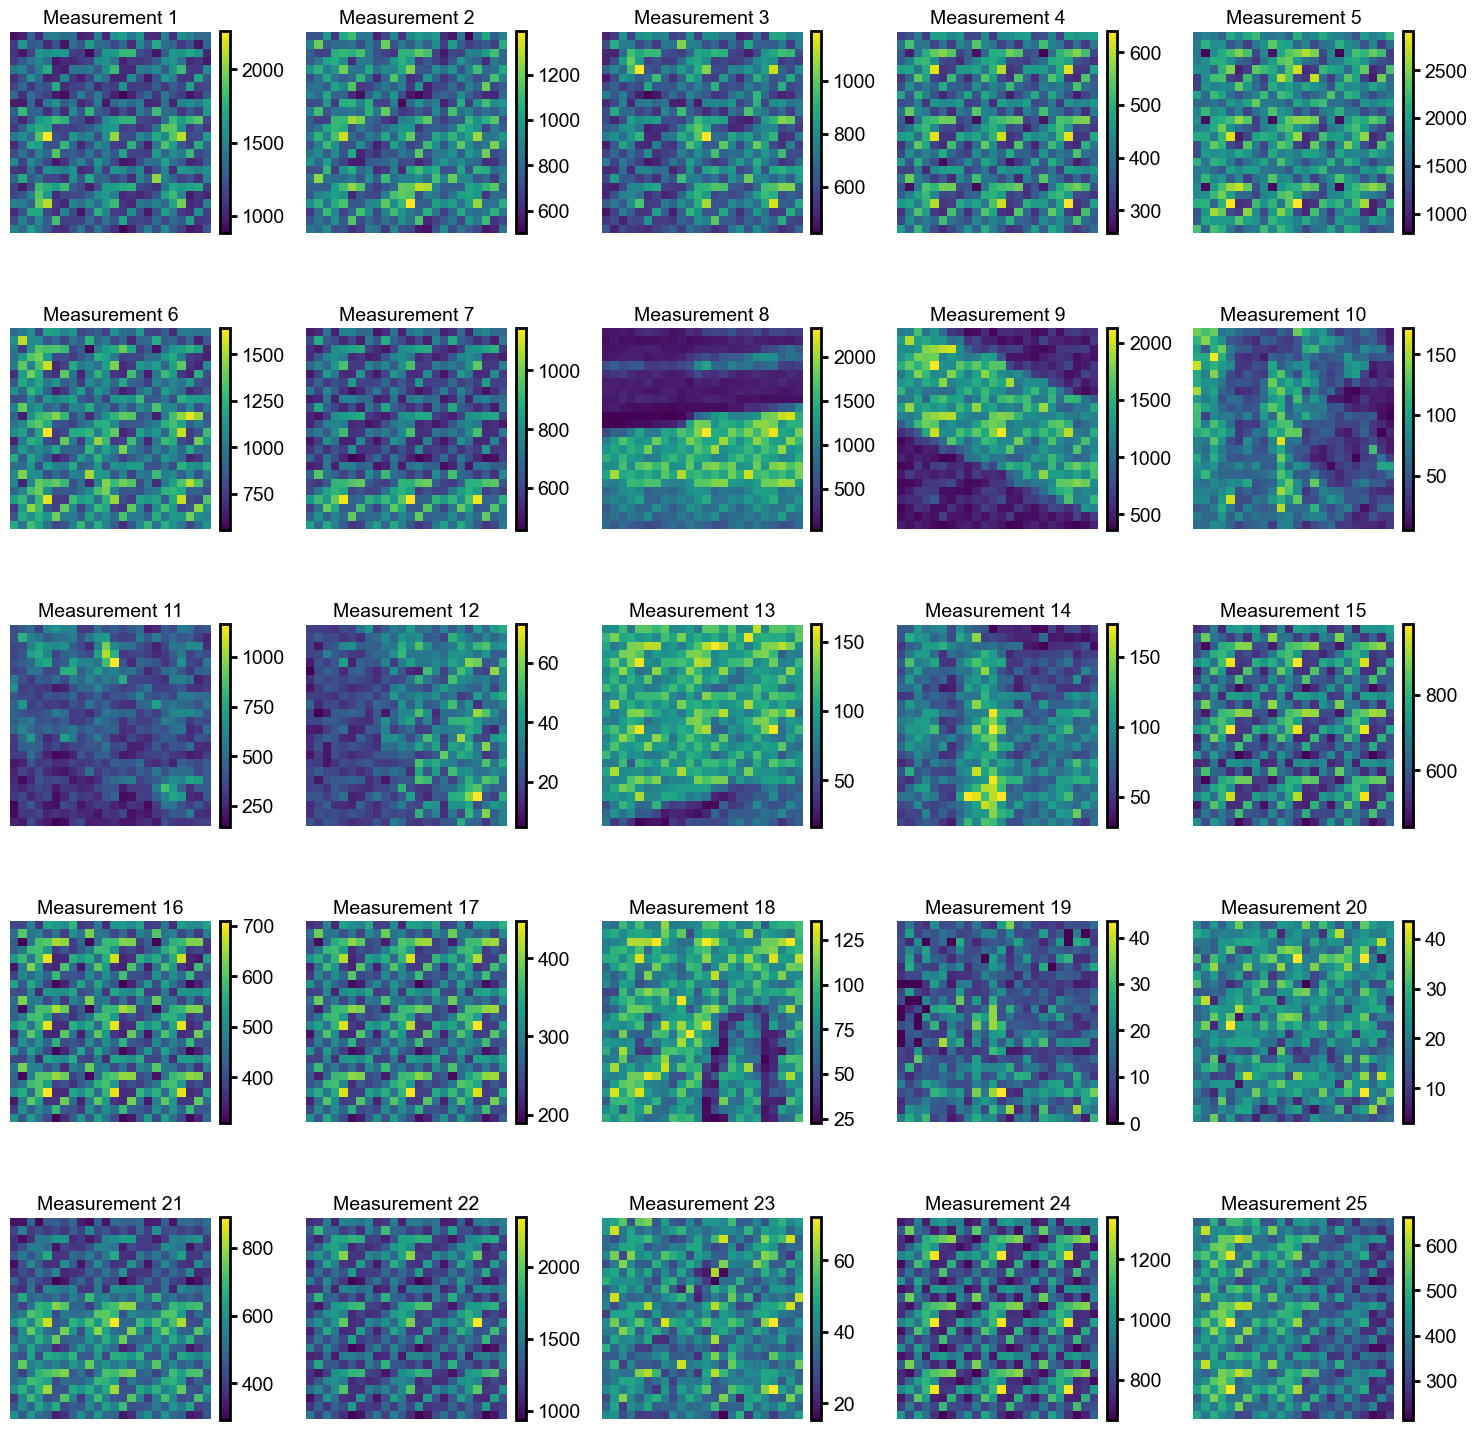

In [10]:
# Display a 4x4 grid of measurements
print(measurements.shape)  # Check the shape of measurements

# Create a figure with a 4x4 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Display the first 16 measurements
for i in range(25):
    if i < len(measurements):
        # Display the measurement
        im = axes[i].imshow(measurements[i], cmap='viridis')
        axes[i].set_title(f"Measurement {i+1}")
        axes[i].axis('off')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    else:
        # Hide unused subplots
        axes[i].axis('off')

plt.tight_layout()
plt.show()
